In [97]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42)  


In [98]:
layer_num=3
hidden_num=64
sym='symetry'
skip=40

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [99]:
def potential(x,k):
    poten=1/2*k*x**2
    return poten

In [100]:
def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i+skip) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [101]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
para_mult=2
La=-5*para_mult
Lb =5*para_mult
L=Lb-La  # domain length
N = 1500*para_mult   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0

k=4
en_num=10
epoch=3000
lr=0.01
real_en=energy(en_num,k,m,h_bar,device,dtype)

model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,k)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num])


initial eigenvalues check:
tensor([ 1.0003,  2.9988,  5.0004,  6.9991,  9.0011, 10.9993, 13.0005, 14.9992,
        17.0003, 18.9990], device='cuda:0')


In [102]:

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[skip:en_num+skip])
    print(real_en)
    
    output=eigenvalues[skip:en_num+skip]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')



epoch: 0
tensor([20.5674, 21.5903, 22.6388, 23.7110, 24.8085, 25.9271, 27.0793, 28.2541,
        29.4466, 30.6679], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([81., 83., 85., 87., 89., 91., 93., 95., 97., 99.], device='cuda:0')
epoch:0,loss:64.53089141845703,time:0.07240438461303711,lr:0.01

epoch: 1
tensor([23.8936, 24.9222, 25.9625, 27.0375, 28.1364, 29.2632, 30.4177, 31.5674,
        32.7671, 33.9756], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([81., 83., 85., 87., 89., 91., 93., 95., 97., 99.], device='cuda:0')

epoch: 2
tensor([27.8178, 28.8368, 29.8793, 30.9559, 32.0532, 33.1693, 34.3139, 35.4817,
        36.6767, 37.8926], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([81., 83., 85., 87., 89., 91., 93., 95., 97., 99.], device='cuda:0')

epoch: 3
tensor([33.4367, 34.4492, 35.4874, 36.5500, 37.6388, 38.7523, 39.8924, 41.0554,
        42.2460, 43.4587], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([81., 83., 85., 87., 89., 91., 93., 95., 97., 99.], device='c

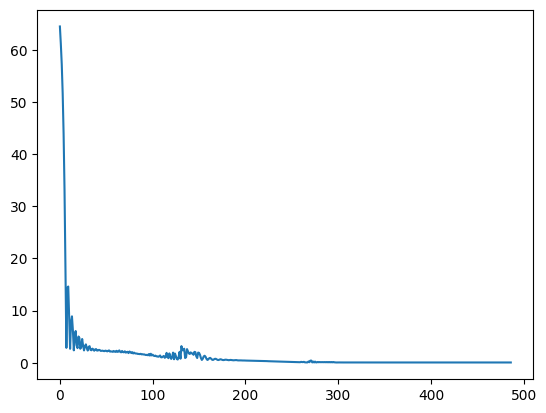

In [103]:
plt.plot(loss_list)
plt.show()

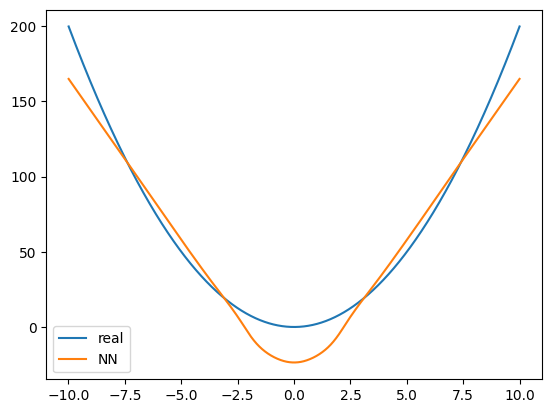

In [104]:

V_NN=model(grid)

os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [105]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 10.914127
max_error: 34.843918
